In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds

# Change sell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def imagToRealMatrix(A):
    return np.vstack((np.concatenate((np.real(A), -np.imag(A)), axis=1), np.concatenate((np.imag(A), np.real(A)), axis=1)))

def imagToRealVector(x):
    return np.hstack((np.real(x), np.imag(x)))

def realToImagVector(x):
    return np.split(x, 2)

def objFunc(A, x, b, weight=1, valueType='real_abs', normType=2):
    '''
    Object function for a single current element
    '''
    if len(A.shape) != 2:
        print("Matrix A should have a shape: (m, n) \n")
        print("Your matrix A shape is {} \n".format(A.shape))
        return
    if len(x.shape) != 1:
        print("Vector x should have a shape: (n,) \n")
        print("Your x shape is {} \n".format(x.shape))
        return
    if len(b.shape) != 1:
        print("Vector b should have a shape: (m,) \n")
        print("Your b shape is {}".format(b.shape))
        return
        
    if valueType=='real':
        realValued_A = imagToRealMatrix(A)
        realValued_x = imagToRealVector(x)
        realValued_b = imagToRealVector(b)
        return weight*np.linalg.norm(realValued_A@realValued_x - realValued_b, ord=normType)
    elif valueType=='real_abs':
        return weight*np.linalg.norm(abs(A@x) - b, ord=normType)
    elif valueType=='complex':
        return weight*np.linalg.norm(A@x - b, ord=normType)
    
def arrayFactor(N, k, d, phi):
    '''
    Calculate the array factor of a given antenna array
        N - number of antennas
        k - wave number
        d - distance between elements
            phi - array of azimuth angles
    return: matrix A
    '''
    M = np.shape(phi)[0]
    A = np.zeros([M, N], dtype=np.complex_)

    for i in range(M):
        a = np.zeros([1, N], dtype=np.complex_);
        for j in range(N):
            a[:, j] = np.exp(1j*k*j*d*np.cos(phi[i]))
        A[i, :] = a
    return A

def coordDescent(A, x, b, idxList):
    """
    Coordinate gradient descent algorithm
        A - m by n matrix 
        x - n by 1 vector
        b - m by 1 vector
        idxList - list of indices for Gradient Descent iterations
    return: x
    """
    numOfIterations = 10
    if len(idxList):
        for i in range(numOfIterations):
            r = b - A@x 
            for j in idxList:
                if j == -1:
                    continue
                a_j = A[:, j];
                x[j] = x[j] + np.dot(a_j, r) / np.dot(a_j, a_j);
                r = r - a_j*np.dot(a_j, r) / np.dot(a_j, a_j); # check formula
    return x

def phaseShift(x, delta, shiftType='linear'):
    """
    Add phase shift to the elements of vector x
    """
    numOfElements = x.shape[0]
    x_shifted = np.array(x, dtype=np.complex_)
    if shiftType=='linear':
        Delta = 0
        for i in range(numOfElements):
            x_shifted[i] = x[i] * np.exp(1j*Delta)
            Delta += delta
        return x_shifted
    else:
        print("Please specify phaseType value \n")
        
def refBeam(N, A, position=90, beamType='hamming', phiStep=0.1):
    phiStart = position - 90
    phiEnd = position + 90
    phiRange = np.radians(np.arange(phiStart, phiEnd, phiStep))
    if A == []:
        lambda_ref = 1
        A = arrayFactor(N, 2*np.pi/lambda_ref, lambda_ref/2, phiRange)
    # Create weights for desired pattern 
    if beamType == 'hamming':
        weights = np.hamming(N)
        weights = weights/np.linalg.norm(weights, 2)
        return abs(A@weights)
    
def plotter(dataX, dataY, styleMod, figsize=(10,5), plotType='normal'):
    """
    High level customised API for plotting.
    """
    plt.figure(figsize=(10, 5))
    if plotType == 'normal':
        for dataYElem, styleElem in zip(dataY, styleMod):
            plt.plot(dataX, dataYElem, styleElem) if len(dataX) else plt.plot(dataYElem, styleElem)
    elif plotType == 'stem':
        for dataYElem, styleElem in zip(dataY, styleMod):
            plt.stem(dataX, dataYElem, styleElem) if len(dataX) else plt.stem(dataYElem, styleElem)
    plt.grid(True)
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


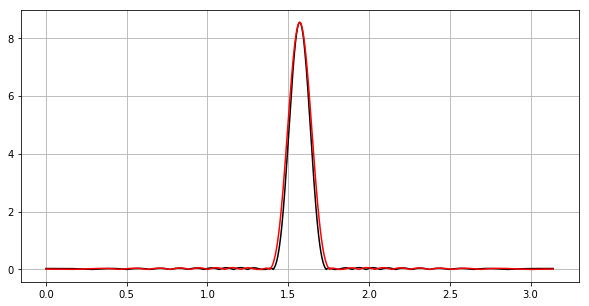

In [3]:
# define the number of antenna elements
numOfAntennaElements = 100
# define distance between two consequent elements
d = 0.5
# define two wavelengths (in nm)
lambda1, lambda2 = (4, 4.5)
# define two array factors
phiRange = np.radians(np.arange(0, 180, 0.1))
A1, A2 = arrayFactor(numOfAntennaElements, 2*np.pi/lambda1, d, phiRange), \
        arrayFactor(numOfAntennaElements, 2*np.pi/lambda2, d, phiRange)

beam1 = refBeam(numOfAntennaElements, A1)
beam2 = refBeam(numOfAntennaElements, A2)

plotter(phiRange, [beam1, beam2], ['k', 'r'])

In [9]:
def getOptCurrentDistribution(AFList, beamList, weightList):
    """
    The main routine where optimal current distribution is calculated for multiple currents at different frequencies
    """
    # number of antenna elements corresponds to the number of columns in the array factor matrix
    numOfAntennaElements = AFList[0].shape[1]
    numOfCurrents = len(AFList)
    
    # define objective function
    f = lambda I: sum(map(objFunc, AFList, np.exp(np.split(I, numOfCurrents)), beamList, weightList))
    
    # define constraints in matrix form: Cx - e >= 0
    C = np.empty(shape=(numOfAntennaElements, numOfAntennaElements*numOfCurrents))
    for i in range(numOfCurrents):
        C[:, i*numOfAntennaElements : (i+1)*numOfAntennaElements] = np.eye(numOfAntennaElements, dtype=np.float)
    cons = {'type':'eq', 'fun': lambda I: -C@I - 20}
    #cons = {'type':'eq', 'fun': lambda I: -C@I - 20}
    #bnds = Bounds(-np.inf*np.ones(numOfAntennaElements * numOfCurrents), 10*np.ones(numOfAntennaElements * numOfCurrents))
    
    # define initial value
    x0 = np.ones(numOfAntennaElements * numOfCurrents)
    
    print("Initial norm of residual: {}".format(f(x0)))
    
    # run optimisation solver
    #result = minimize(fun=f, x0=x0, constraints=cons, options={'ftol': 1e-8, 'disp': True, 'maxiter': 1000}, bounds=bnds)
    result = minimize(fun=f, x0=x0, constraints=cons)
    
    print("Optimisation problem solved. Resulting norm of residual: {}".format(f(result.x)))
    
    return np.split(result.x, numOfCurrents)

Initial norm of residual: 3663.979126437881
Optimisation problem solved. Resulting norm of residual: 108.93815333148135


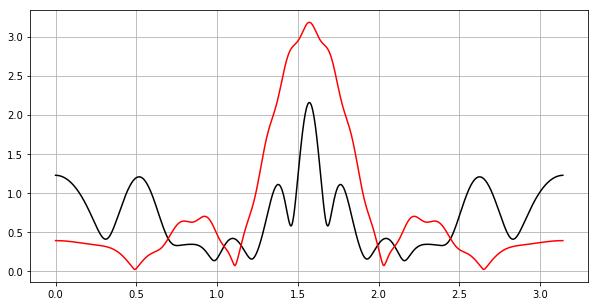

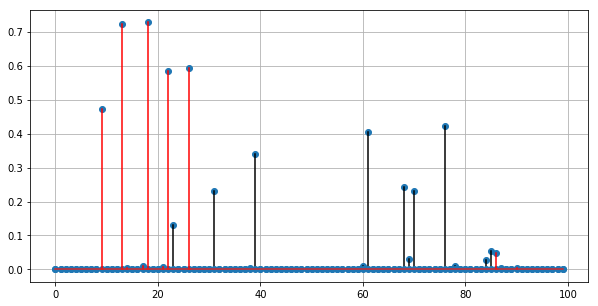

CPU times: user 42.5 s, sys: 1.02 s, total: 43.5 s
Wall time: 8.68 s


In [10]:
%%time

J = getOptCurrentDistribution(AFList=[A1, A2], beamList=[beam1, beam2], weightList=[1.0, 1.0])

I1_res, I2_res = np.exp(J)
plotter(phiRange, [abs(A1@I1_res), abs(A2@I2_res)], ['k', 'r'])
plotter([], [abs(I1_res), abs(I2_res)], styleMod=['k', 'r'], plotType='stem')

<function matplotlib.pyplot.show(*args, **kw)>

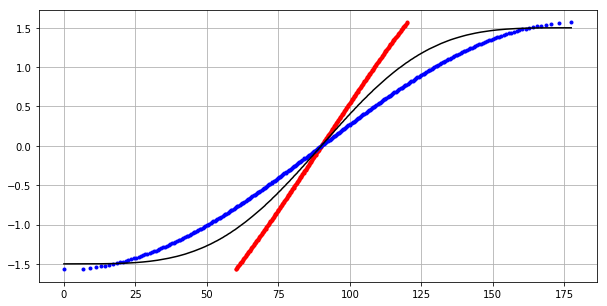

In [59]:
# plotting relationship between peak value and corresponding linear phase shift
deltas = np.arange(-np.pi/2, np.pi/2, 0.01)
peak_values2 = []
peak_values1 = []
peak_values_theory = []

# record peak value and angle relationship
angPeakDict = {}

for d in deltas:
    peak_values2.append(np.argmax(abs(A2@phaseShift(np.exp(I2_res), delta=d)))*0.1)
    angPeakDict[np.argmax(abs(A2@phaseShift(np.exp(I2_res), delta=d)))*0.1 - 90] = d
    peak_values1.append(np.argmax(abs(A1@phaseShift(np.exp(I1_res), delta=d)))*0.1)
    peak_values_theory.append(1.5*np.sin(d))
    
peak_values2 = np.array(peak_values2)
peak_values1 = np.array(peak_values1)
peak_values_theory = np.array(peak_values_theory)

plt.figure(figsize=(10, 5))
plt.plot(peak_values1, deltas, ".r")
plt.plot(peak_values2, deltas, ".b")
plt.plot(peak_values2, peak_values_theory, "k")
plt.grid(True)
plt.show

In [67]:
from ipywidgets import interact, interactive, fixed, interact_manual

# define a direction
def Test(beamDir = 0):
    beamDirIdx = min(angPeakDict, key=lambda x: abs(x - beamDir))
    # form a beam in desired direction
    beamTest = refBeam(numOfAntennaElements, [], position=90-beamDir)
    #plotter(phiRange, [beamTest], ["k"])
    shiftedI2 = phaseShift(I2_res, delta=angPeakDict[beamDirIdx])

    listOfCurrentsToOptimise = np.arange(0, 2*numOfAntennaElements)
    listOfCurrentsToOptimise[np.where( abs(imagToRealVector(shiftedI2)) < 0.01 )] = -1

    test_cd = coordDescent(imagToRealMatrix(A2), imagToRealVector(shiftedI2), np.hstack((beamTest, beamTest*0)), idxList=listOfCurrentsToOptimise)
    I2_new = realToImagVector(test_cd)[0] + 1j*realToImagVector(test_cd)[1]
    plotter(phiRange, [abs(A2@I1_res), abs(A2@I2_new), beamTest], ['k', 'r', '.b'])

In [68]:
interact(Test, beamDir=(-90, 90, 5));

interactive(children=(IntSlider(value=0, description='beamDir', max=90, min=-90, step=5), Output()), _dom_clas…

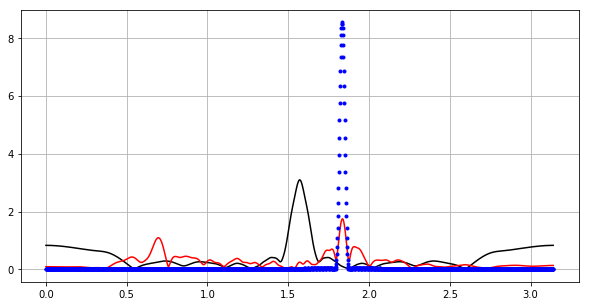

Initial norm of residual: 3908.018827067379
Optimisation problem solved. Resulting norm of residual: 67.52665867441473


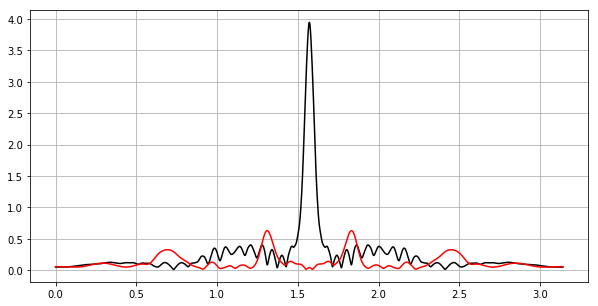

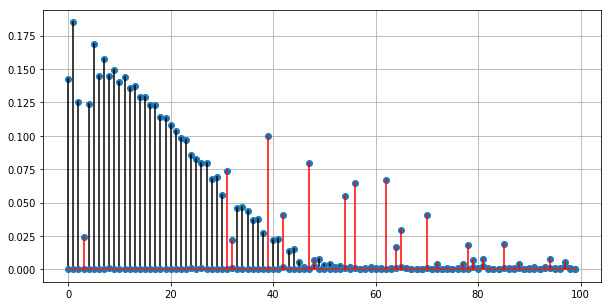

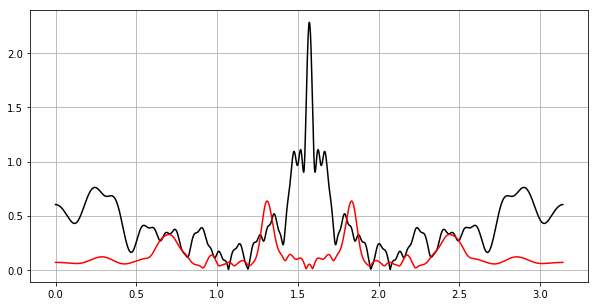

In [66]:
beamDir = 15
beamDirIdx = min(angPeakDict, key=lambda x: abs(x - beamDir))
# form a beam in desired direction
beamTest = refBeam(numOfAntennaElements, [], position=90-beamDir)
#plotter(phiRange, [beamTest], ["k"])
shiftedI2 = phaseShift(I2_res, delta=angPeakDict[beamDirIdx])

listOfCurrentsToOptimise = np.arange(0, 2*numOfAntennaElements)
listOfCurrentsToOptimise[np.where( abs(imagToRealVector(shiftedI2)) < 0.01 )] = -1

test_cd = coordDescent(imagToRealMatrix(A2), imagToRealVector(shiftedI2), np.hstack((beamTest, beamTest*0)), idxList=listOfCurrentsToOptimise)
I2_new = realToImagVector(test_cd)[0] + 1j*realToImagVector(test_cd)[1]
plotter(phiRange, [abs(A2@I1_res), abs(A2@I2_new), beamTest], ['k', 'r', '.b'])
#print(np.argmax(abs(A2@phaseShift(np.exp(I2_res), delta=0.4)))*0.1 - 90)
#print(np.linalg.matrix_rank(A2@np.diag(np.angle(I2_new))))
J_new = getOptCurrentDistribution(AFList=[A1, A2@np.diag(np.angle(I2_new))], beamList=[beam1, beamTest], weightList=[1, 1.3])
I1_new_res, I2_new_res = np.exp(J_new)
plotter(phiRange, [abs(A1@I1_new_res), abs(A2@np.diag(np.angle(I2_new))@I2_new_res)], ['k', 'r'])
plotter([], [abs(I1_new_res), abs(np.diag(np.angle(I2_new))@I2_new_res)], styleMod=['k', 'r'], plotType='stem')

I2_new2 = I2_new_res * np.angle(I2_new)
#beamTest = refBeam(numOfAntennaElements, [], position=90-beamDir)
#plotter(phiRange, [beamTest], ["k"])

listOfCurrentsToOptimise = np.arange(0, 2*numOfAntennaElements)
listOfCurrentsToOptimise[np.where( abs(imagToRealVector(I2_new2)) < 0.005 )] = -1

test_cd = coordDescent(imagToRealMatrix(A2), imagToRealVector(I2_new2), np.hstack((beamTest, beamTest*0)), idxList=listOfCurrentsToOptimise)
I2_new3 = realToImagVector(test_cd)[0] + 1j*realToImagVector(test_cd)[1]
plotter(phiRange, [abs(A2@I2_res), abs(A2@I2_new3)], ['k', 'r'])

In [ ]:
test_cd = coordDescent(imagToRealMatrix(A2), imagToRealVector(I2_new2), np.hstack((beamTest, beamTest*0)), idxList=listOfCurrentsToOptimise)
I2_new3 = realToImagVector(test_cd)[0] + 1j*realToImagVector(test_cd)[1]
plotter(phiRange, [abs(A2@I2_res), abs(A2@I2_new3)], ['k', 'r'])

In [ ]:


J2 = np.exp(I2_res)
#a = np.arange(0, 2*numOfAntennaElements)
#a[np.where( J2>0.01 )] = -1
#print(a)
#print(J2[np.where( J2>0.01 )])

beam_test = refBeam(numOfAntennaElements, [], position=+90-14.8) # correspond to d = 1
#plt.figure(figsize=(10, 5))
#plt.plot(phiRange, beam_test, "r")
#plt.grid(True)
#plt.show()
shiftedJ2 = phaseShift(J2, delta=0.4)
a = np.arange(0, 2*numOfAntennaElements)
a[np.where( abs(imagToRealVector(shiftedJ2))<0.01 )] = -1
print(a)

test_cd = coordDescent(imagToRealMatrix(A2), imagToRealVector(shiftedJ2), np.hstack((beam_test, beam_test*0)), idxList=a)
I2_new = realToImagVector(test_cd)[0] + 1j*realToImagVector(test_cd)[1]

plt.figure(figsize=(10, 5))
#plt.plot(phiRange, abs(beam1), ".k")
plt.plot(phiRange, abs(beam_test), ".b")
plt.plot(phiRange, abs(A1@phaseShift(np.exp(I1_res), delta=0)), "k")
plt.plot(phiRange, abs(A2@shiftedJ2), "r")
plt.plot(phiRange, abs(A2@I2_new), "b")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.stem(abs(np.exp(I1_res)), "-k")
plt.stem(abs(I2_new), "-r")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(phiRange, abs(A2@I2_new), "b")
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
# for DEBUG
# f = lambda I: objFunc(A=A1, b=beam1, x=np.exp(np.split(I, 2)[0]), weight=1.3, valueType='real')+ \
#     objFunc(A=A2, b=beam2, x=np.exp(np.split(I, 2)[1]), valueType='real')
# print(f(x0))
# f1 = lambda I: sum(map(objFunc, [A1, A2], np.exp(np.split(I, 2)), [beam1, beam2], [1.3, 1]))
# print(f1(x0))

In [ ]:
%%time
# define objective function
f = lambda I: objFunc(A=A1, b=beam1, x=np.exp(np.split(I, 2)[0]), valueType='real')*1.3 + \
    objFunc(A=A2, b=beam2, x=np.exp(np.split(I, 2)[1]), valueType='real')
# define constraints in matrix form: Cx - e >= 0
# C = np.hstack((np.eye(numOfAntennaElements, dtype=np.float_), np.eye(numOfAntennaElements, dtype=np.float_)))

C = np.empty(shape=(numOfAntennaElements, numOfAntennaElements*3), dtype=np.float)
for i in range(3):
    C[:, i*numOfAntennaElements : (i+1)*numOfAntennaElements] = np.eye(numOfAntennaElements, dtype=np.float)

print(C.shape)
cons = {'type':'ineq', 'fun': lambda I: -C@I - 10}
# define initial value
x0 = np.hstack((np.ones(numOfAntennaElements), np.ones(numOfAntennaElements)))
# run optimisation solver
#test_min = minimize(fun=f, x0=x0, constraints=cons)